In [1]:
import pandas as pd
import matplotlib.pyplot as plot
import numpy as np

Source data:
Table 20 from: https://www.ons.gov.uk/peoplepopulationandcommunity/personalandhouseholdfinances/incomeandwealth/datasets/theeffectsoftaxesandbenefitsonhouseholdincomefinancialyearending2014

# Read in the data

In [2]:
data=pd.read_excel('data/data.xlsx',sheet_name='Deciles')
# Print the column names
print('{} columns:'.format(len(data.columns)))
print(data.columns.tolist())
decLab='Decile (Equivalised Original Household Income)'

80 columns:
['Decile', 'OriginalIncomeEqMin', 'OriginalIncomeEqMax', 'Nindividuals', 'Nhouseholds', 'WagesSalaries', 'BenInKind', 'SelfEmployed', 'Pensions', 'Investment', 'OtherIncome', 'OriginalIncome', 'OriginalIncomeEq', 'JSAcontribBased', 'JSAincomeBased', 'ESA', 'Incapacity', 'StatePension', 'CarersAllowance', 'TaxableBenefits', 'IncomeSupport', 'Maternity', 'ChildBenefit', 'TaxCredits', 'HouseingBenefit', 'PensionCredit', 'WidowsBenefits', 'WarPension', 'AttendanceAllowance', 'DLA', 'PIP', 'SDA', 'IndustrialInjury', 'StudentSUpport', 'OtherBenefits', 'DirectBenefits', 'KeptBenefits', 'GrossIncome', 'GrossIncomeEq', 'IncomeTax', 'EmployeeNI', 'StudentLoan', 'CouncilTax', 'DirectTax', 'fracIncome', 'DisposableIncome', 'Unnamed: 46', 'DisposableIncomeEq', 'VAT', 'Tobacco', 'BeerCider', 'WineSpirit', 'Oils', 'VehicleExcise', 'TV', 'StampDuty', 'Customs', 'Betting', 'Insurance', 'Air', 'NatLottery', 'OtherIndTax', 'CommercialRates', 'EmployerNI', 'OilsInter', 'VehicleExciseInter', 'O

Define some convenience variables for key columns

In [3]:
# extrace columns from data (for easy)
decile=data['Decile']
nHouseholds=data['Nhouseholds']
origIncome=data['OriginalIncome']
origIncomeEq=data['OriginalIncomeEq']
dirBen=data['DirectBenefits']
keptBen=data['KeptBenefits']
taxableBen=data['TaxableBenefits']
grossIncome=data['GrossIncome']
incomeTax=data['IncomeTax']
dirTax=data['DirectTax']
dispIncome=data['DisposableIncome']
indirTax=data['IndirectTax']
postIncome=data['PostTaxIncome']
kindBen=data['BenefitsInKind']
finalIncome=data['FinalIncome']

# equivalent household size in decile (calculated by total income / equivalised income)
nEquiv=data['OriginalIncome']/data['OriginalIncomeEq']

## Quick look at data

### Original Equivalised Income

Original income includes:
* Wages and salaries
* Imputed income from benefits in kind
* Self-employment income
* Private pensions, annuities
* Investment income
* Other income

Text(0.5,1,'Original Equivalised Income (log scale)')

/Applications/anaconda3/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


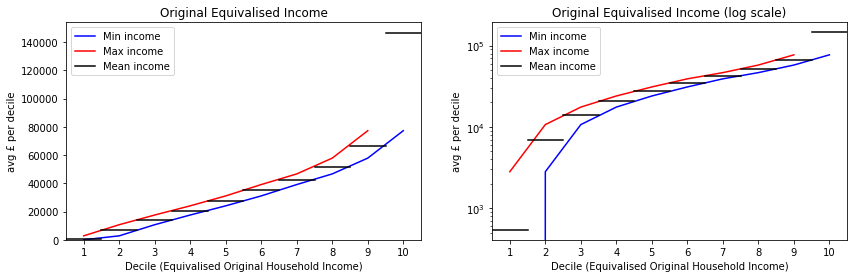

In [4]:
plot.figure(figsize=(14,4))
plot.subplot(1,2,1)
# plot.plot(data['Decile']-0.5,data['OriginalIncomeEq'],'kx',label='Mean income')
plot.plot(data['Decile']-0.5,data['OriginalIncomeEqMin'],'b-',label='Min income')
plot.plot(data['Decile']-0.5,data['OriginalIncomeEqMax'],'r-',label='Max income')
plot.plot([0,0,1],[0,origIncomeEq[0],origIncomeEq[0]],'k-',label='Mean income')
for d in range(1,len(decile)):
    plot.plot([d,d+1],[origIncomeEq[d],origIncomeEq[d]],'k-')
plot.xlim(0,10)
plot.xticks(np.arange(0.5,10.5),np.arange(1,11))
plot.ylim(0,plot.ylim()[1])
plot.xlabel(decLab)
plot.ylabel('avg £ per decile')
plot.legend()
plot.title('Original Equivalised Income')
plot.subplot(1,2,2)
# plot.plot(data['Decile']-0.5,data['OriginalIncomeEq'],'kx',label='Mean income')
plot.plot(data['Decile']-0.5,data['OriginalIncomeEqMin'],'b-',label='Min income')
plot.plot(data['Decile']-0.5,data['OriginalIncomeEqMax'],'r-',label='Max income')
plot.plot([0,1],[origIncomeEq[0],origIncomeEq[0]],'k-',label='Mean income')
for d in range(1,len(decile)):
    plot.plot([d,d+1],[origIncomeEq[d],origIncomeEq[d]],'k-')
plot.xlim(0,10)
plot.xticks(np.arange(0.5,10.5),np.arange(1,11))
# plot.ylim(0,plot.ylim()[1])
plot.xlabel(decLab)
plot.ylabel('avg £ per decile')
plot.yscale('log')
plot.legend()
plot.title('Original Equivalised Income (log scale)')

Worth noting that the mean is not quite halfway between the min and the max in each bin, so we know that we don't have linear distributions within each bin. We also fix the minimum of the first decile to be 0, but do not know the maximum of the highest decile

### Household size
Disposable income is equivalised to rank households. This reflects the common sense notion that, in order to enjoy a comparable standard of living, a household of, for example, three adults will need a higher level of income than a household of one person.

In this analysis the modified-OECD scale has been rescaled so that a two adult household equivalence value is 1.0.

* First adult: 0.67
* Second and subsequent adults 0.33 (per adult)
* Child aged 14 and over 0.33
* Child aged 13 and under 0.2

Text(0,0.5,'Equivalent Household size')

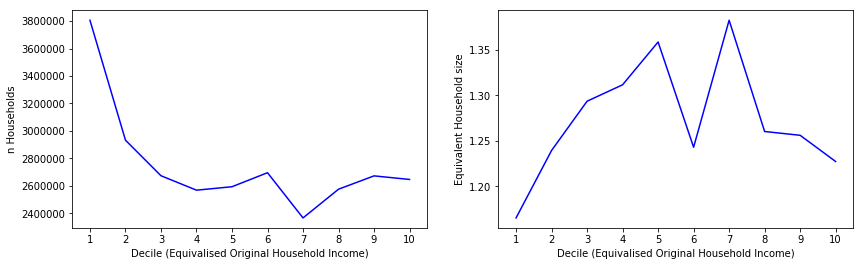

In [5]:
plot.figure(figsize=(14,4))
plot.subplot(1,2,1)
plot.plot(decile,nHouseholds,'b-')
plot.xlim(0.5,10.5)
plot.xticks(np.arange(1,11))
# plot.ylim(0,plot.ylim()[1])
plot.xlabel(decLab)
plot.ylabel('n Households')

nHouseMean=np.sum(nHouseholds)/10
plot.subplot(1,2,2)
plot.plot(decile,nEquiv,'b-')
plot.xlim(0.5,10.5)
plot.xticks(np.arange(1,11))
# plot.ylim(0,plot.ylim()[1])
plot.xlabel(decLab)
plot.ylabel('Equivalent Household size')
# plot.axhline(0,c='k')
# plot.axhline(1.2,c='gray',ls='--')

### Taxable Benefits
Taxable benefits include:
* Jobseeker's allowance (contribution based)
* Jobseeker's allowance (income based)
* Employment and support allowance
* Incapacity benefit
* State pension
* Carer's allowance

They are added to original income to give the taxable income

Text(0,0.5,'Taxable Benefits')

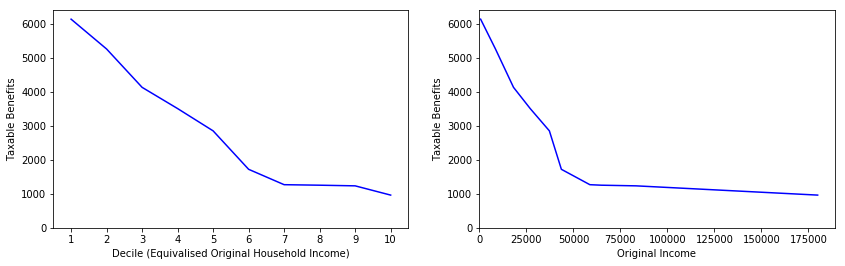

In [6]:
plot.figure(figsize=(14,4))
plot.subplot(1,2,1)
plot.plot(decile,taxableBen,'b-')
plot.xlim(0.5,10.5)
plot.xticks(np.arange(1,11))
plot.ylim(0,plot.ylim()[1])
plot.xlabel(decLab)
plot.ylabel('Taxable Benefits')

plot.subplot(1,2,2)
plot.plot(origIncome,taxableBen,'b-')
plot.xlim(0,plot.xlim()[1])
plot.ylim(0,plot.ylim()[1])
plot.xlabel('Original Income')
plot.ylabel('Taxable Benefits')

# Income model
### Model the income distribution (basic)

Assume a linear income distribution ($Y$) vs ranking ($n$): $Y(n) = Y_0 + an$, with $Y(N)=Y_1$ and $\Delta Y(n)=Y(n)-Y_1$.

We taper the bottom end to zer at some point in the lowest decile. The maximum is fixed, and the gradient is set such that the mean in that decile is the same as measured.

We assume the gradient in the top decile is linear - this is not true (it is highly peaked towards higher incomes), but since we care about averages it should work out.

In [7]:
# construct model for equivalised income
y0Eq = np.array(data['OriginalIncomeEqMin'])
y1Eq = np.array(data['OriginalIncomeEqMax'])
ybarEq = np.array(data['OriginalIncomeEq'])

# find the gradient in each decile
# where no max (top decile, use the mean as the mid-point
model_aEq=np.where(np.isfinite(y1Eq),(y1Eq-y0Eq),(ybarEq-y0Eq)*2)

# adjust for zero-income
# Find the gradient which gives the same mean in the bottom decile 
n_zeroEq=1-(2*ybarEq[0]/y1Eq[0])
model_aEq[0]=y1Eq[0]/(1-n_zeroEq)
# adjust the bottom limit so the model works
y0Eq[0]=y1Eq[0]-model_aEq[0]

# calculate number of households with zero income
n0houseEq=n_zeroEq*nHouseholds[0]
# number of "equivalent individuals" with zero income (i.e. nHouseholds * Equiv Household Size)
n0equivEq=n0houseEq*nEquiv[0]
print('{:.1f}m households ({:.1f} equivalent individuals) with zero equivalent income'.format(n0houseEq/1e6,n0equivEq/1e6))

# calculate maximum income
maxIncomeEq=y0Eq[-1]+model_aEq[-1]
print('Modelling equivalent income:')
print('Modelled max equivalent income: £{:.1f}k'.format(maxIncomeEq/1e3))
# print('model_Eq',model_aEq)

# construct model for household income (from equivalised income)
y0Hh = np.array(data['OriginalIncomeEqMin'])
y1Hh = np.array(data['OriginalIncomeEqMax'])
# print(y0Hh,y1Hh)
# multiply boundaries by average of upper and lower equivalent household size (to prevent jumps)
for q in range(0,9):
    y1Hh[q]=y1Hh[q] * 0.5*(nEquiv[q]+nEquiv[q+1])
    y0Hh[q+1]=y1Hh[q]
# mean household income
ybarHh = np.array(origIncome)

# find the gradient in each decile
# where no max (top decile) assume the mean is the mid-point
model_aHh=np.where(np.isfinite(y1Hh),(y1Hh-y0Hh),(ybarHh-y0Hh)*2)

# adjust for zero-income
# Find the gradient which gives the same mean as data in the bottom decile 
n_zeroHh=1-(2*ybarHh[0]/y1Hh[0])
model_aHh[0]=y1Hh[0]/(1-n_zeroHh)
# adjust the bottom limit so the model works
y0Hh[0]=y1Hh[0]-model_aHh[0]
# print(y0Hh,y1Hh)

# number of households, and equivalised individuals, with zero income
n0houseHh=n_zeroHh*nHouseholds[0]
n0equivHh=n0houseHh*nEquiv[0]
print('{:.1f}m households ({:.1f} equivalent individuals) with zero household income'.format(n0houseHh/1e6,n0equivHh/1e6))

# calculate maximum income
maxIncomeHh=y0Hh[-1]+model_aHh[-1]
print('Modelling household income:')
print('Modelled max household income: £{:.1f}k'.format(maxIncomeHh/1e3))

# print('model_Hh',model_aHh)
# define the simple model function
def modelA(n,modelEq=model_aEq,modelHh=model_aHh,y0Eq=y0Eq,y0Hh=y0Hh,nEquiv=nEquiv,Eq=True):
    # n is in the range 0-1 over full population
    # convert to decile
    if np.isscalar(n):
        q=np.min([9,int(np.floor(n*10))])
    else:
        q = np.floor(n*10).astype(int)
    # calculate the modelled earnings

    if Eq:
        model=modelEq
        y0=y0Eq
    else:
        model=modelHh
        y0=y0Hh
    mody=np.maximum(0,y0[q] + model[q]*(10*n-q))
#     print('model',model)
    # mody = mody * nEquiv[q]
    return(mody)
# print('Hh',modelA(0.5,Eq=False))
# print('Eq',modelA(0.5,Eq=True))

2.3m households (2.7 equivalent individuals) with zero equivalent income
Modelling equivalent income:
Modelled max equivalent income: £216.0k
2.4m households (2.8 equivalent individuals) with zero household income
Modelling household income:
Modelled max household income: £264.0k


### Sanity check
Check that the model looks sensible - plot the gradient across each decile as a sanity check

Text(0.5,1,'Household Income Gradient')

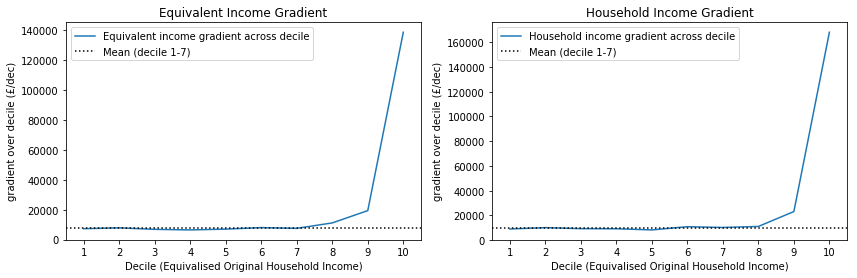

In [8]:
plot.figure(figsize=(14,4))
plot.subplot(1,2,1)
plot.plot(decile,model_aEq,label='Equivalent income gradient across decile')
plot.axhline(np.mean(model_aEq[1:-2]),c='k',ls=':',label='Mean (decile 1-7)')
plot.xlabel(decLab)
plot.xlim(0.5,10.5)
plot.xticks(np.arange(1,11))
plot.legend()
plot.ylabel('gradient over decile (£/dec)')
plot.title('Equivalent Income Gradient')

plot.subplot(1,2,2)
plot.plot(decile,model_aHh,label='Household income gradient across decile')
plot.axhline(np.mean(model_aHh[1:-2]),c='k',ls=':',label='Mean (decile 1-7)')
plot.xlabel(decLab)
plot.xlim(0.5,10.5)
plot.xticks(np.arange(1,11))
plot.legend()
plot.ylabel('gradient over decile (£/dec)')
plot.title('Household Income Gradient')

As expected, the gradient is roughly constant, increasing at the highest incomes. The gradient in the lowest decile is believable.

### Test model
test the model and compare with the published deciles and means

Total equivalised income (measured): £1076.8bn
Total equivalised income (modelled): £1084.0bn
Relative Error: 0.67%
Total household income (measured): £1364.4bn
Total household income (modelled): £1373.0bn
Relative Error: 0.63%


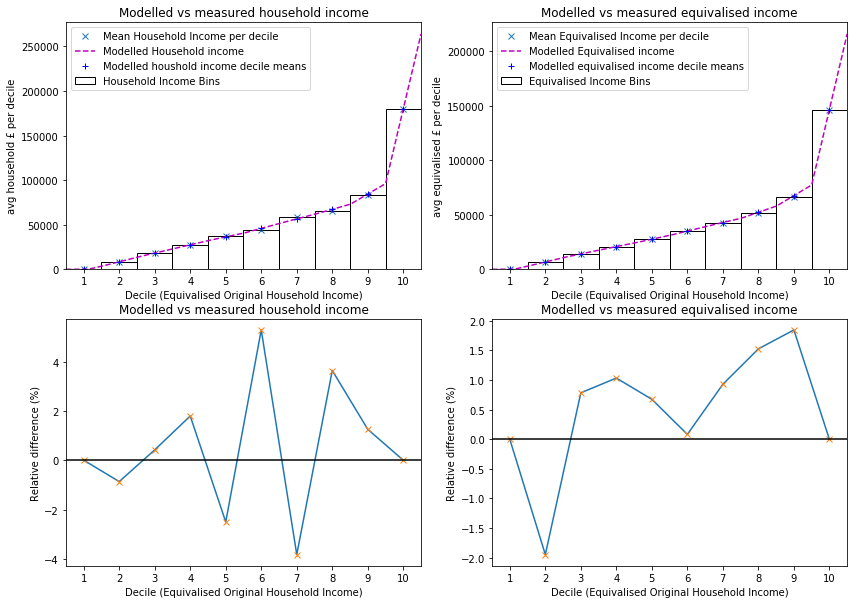

In [9]:
# need a lot of bins so sample it fully
relBin=1e-6 # bin size as fraction of total population
narr=np.arange(0,1,relBin) # position of bin in population (0=lowest income, 1 = highest)
harr=np.zeros_like(narr) # array to store households

yarr=np.array(modelA(narr,Eq=False))
yarrEq=np.array(modelA(narr,Eq=True))

origEqMod=np.zeros_like(origIncome)
origMod=np.zeros_like(origIncome)
# cycle through deciles
for q in np.arange(1,11):
    # get bins in decile
    ind=np.where((narr<q/10)&(narr>=(q-1)/10))
    yind=yarrEq[ind]

    # calculate number of households in bin
    harr[ind]=nHouseholds[q-1]/len(yind)
    # print(q,yarr[ind])
    
    # calculate mean equivalised and household income
    origEqMod[q-1]=np.mean(yarrEq[ind])
    origMod[q-1]=np.mean(yarr[ind])

# offset of modelled original income (equivalised and total household) from data
origEqOffset=origEqMod-origIncomeEq
origOffset=origMod-origIncomeEq

# calculate totals for country
totIncomeMeas=np.sum(origIncome*nHouseholds) # total household income (data)
totIncomeMod=np.sum(origMod*nHouseholds) # total household income (model)
totIncomeRelErr=(totIncomeMod/totIncomeMeas)-1 # relative difference of model w.r.t data for total household income

totIncomeEqMeas=np.sum(origIncomeEq*nHouseholds) # total equivalised household income (data)
totIncomeEqMod=np.sum(origEqMod*nHouseholds) # total equivalised household income (model)
totIncomeEqRelErr=(totIncomeEqMod/totIncomeEqMeas)-1 # relative difference of model w.r.t data for equivalised income

# plot data and model
plot.figure(figsize=(14,10))
plot.subplot(2,2,1)
plot.plot(decile-0.5,origIncome,'x',label='Mean Household Income per decile')
plot.bar(decile-0.5,origIncome,width=1,ls='-',fc='m',fill=None,label='Household Income Bins')
plot.plot(narr*10,yarr,'m--',label='Modelled Household income')
plot.plot(decile-0.5,origMod,'b+',label='Modelled houshold income decile means')
plot.xlim(0,10)
plot.xticks(np.arange(0.5,10.5),np.arange(1,11))
# plot.ylim(0,plot.ylim()[1])
plot.xlabel(decLab)
plot.ylabel('avg household £ per decile')
plot.title('Modelled vs measured household income')
plot.legend()
# plot.ylim(1e2,1e5)
# plot.yscale('log')

plot.subplot(2,2,2)
plot.plot(decile-0.5,origIncomeEq,'x',label='Mean Equivalised Income per decile')
plot.bar(decile-0.5,origIncomeEq,width=1,ls='-',fc='m',fill=None,label='Equivalised Income Bins')
plot.plot(narr*10,yarrEq,'m--',label='Modelled Equivalised income')
plot.plot(decile-0.5,origEqMod,'b+',label='Modelled equivalised income decile means')
plot.xlim(0,10)
plot.xticks(np.arange(0.5,10.5),np.arange(1,11))
# plot.ylim(0,plot.ylim()[1])
plot.xlabel(decLab)
plot.ylabel('avg equivalised £ per decile')
plot.title('Modelled vs measured equivalised income')
plot.legend()
# plot.ylim(1e2,1e5)
# plot.yscale('log')

plot.subplot(2,2,3)
plot.plot(decile,100*(origMod/origIncome - 1))
plot.plot(decile,100*(origMod/origIncome - 1),'x')
plot.xlabel(decLab)
plot.axhline(0,c='k')
plot.xlim(0.5,10.5)
plot.xticks(np.arange(1,11))
plot.ylabel('Relative difference (%)')
plot.title('Modelled vs measured household income')

plot.subplot(2,2,4)
plot.plot(decile,100*(origEqMod/origIncomeEq - 1))
plot.plot(decile,100*(origEqMod/origIncomeEq - 1),'x')
plot.xlabel(decLab)
plot.axhline(0,c='k')
plot.xlim(0.5,10.5)
plot.xticks(np.arange(1,11))
plot.ylabel('Relative difference (%)')
plot.title('Modelled vs measured equivalised income')

print('Total equivalised income (measured): £{:.1f}bn'.format(totIncomeEqMeas/1e9))
print('Total equivalised income (modelled): £{:.1f}bn'.format(totIncomeEqMod/1e9))
print('Relative Error: {:.2f}%'.format(100*totIncomeEqRelErr))
print('Total household income (measured): £{:.1f}bn'.format(totIncomeMeas/1e9))
print('Total household income (modelled): £{:.1f}bn'.format(totIncomeMod/1e9))
print('Relative Error: {:.2f}%'.format(100*totIncomeRelErr))
# print('Total income (modelled check): £{:.1f}bn'.format(totIncomeMod2/1e9))
# print('Relative Error (check): {:.2f}%'.format(100*totIncomeRelErr2))


The model matches perfectly in the top & bottom deciles, by design, but over-predicts in most of the others for equivalised income. The model is a within 1% of the data for total national income. 

The variation between deciles is higher for household income because the boundaries are estimated.

### Model the distribution (advanced)
Create a model of income for each decile, $Y_d$, as a function of position in the decile $n=[0,N]$. We use a 2-order polynomial: $Y_d(n) = Y_{d,0} + a_dn + b_d n^2$, with $Y_{d,1}=Y_d(N)$, $Y_{d,0.5} = Y_d(\frac{N}{2})$ and $\overline{Y_d}=\int_0^N Y_d(n) dn$.

For deciles 2-9, fix $a$ and $b$ such that $Y_0$, $Y_1$ and $\overline{Y}$ are as measured.

Keep the lowest decile (decile 1) as linear, as per basic model, with $b=0$, and $a$ fixed to match measured $\overline{Y}$. This gives a value $n_0$, such that $Y(n_0)=Y_1 - a(N-n_0) = 0$.

Fix the value of $a$ for the highest decile (decile 10) to the final gradient of decile 9, and add $bn^2$ term to match measured $\overline{Y}$.


In [26]:
# get data
y0Eqb = np.array(data['OriginalIncomeEqMin'])
y1Eqb = np.array(data['OriginalIncomeEqMax'])
ybarEqb = np.array(data['OriginalIncomeEq'])
dyEqb=y1Eqb-y0Eqb
y05Eqb=0.5*(y0Eqb+y1Eqb)

# find the gradient in each decile
# where no max (top decile, use the mean as the mid-point
model_Eqb=np.zeros((len(y0Eqb),2))
model_Eqb[:,0]=6*(ybarEqb - y05Eqb) + dyEqb
model_Eqb[:,1]=6*(y05Eqb - ybarEqb)

# adjust for zero-income
# Find the gradient which gives the same mean in the bottom decile 
n_zeroEqb=1-(2*ybarEqb[0]/y1Eqb[0])
model_Eqb[0]=[y1Eqb[0]/(1-n_zeroEqb),0]
# adjust the bottom limit so the model works
y0Eqb[0]=y1Eqb[0]-model_Eqb[0,0]

# fix the parameters of the highest decile such that the mean matches the data
model_Eqb[-1,0]=model_Eqb[-2,0]+2*model_Eqb[-2,1]
model_Eqb[-1,1]=3*(ybarEqb[-1] - y0Eqb[-1] - model_Eqb[-1,0]/2)

# number of households, and equivalised individuals, with zero income
n0houseEqb=n_zeroEqb*nHouseholds[0]
n0equivEqb=n0houseEqb*nEquiv[0]
print('{:.1f}m households ({:.1f} equivalent individuals) with zero equivalised income'.format(n0houseEqb/1e6,n0equivEqb/1e6))

# calculate maximum income
maxIncomeEqb=y0Eqb[-1] + model_Eqb[-1,0] + model_Eqb[-1,1]
print('Modelling equivalised income:')
print('Modelled max equivalised income: £{:.1f}k'.format(maxIncomeEqb/1e3))

# get total household income (equivalised income * equivalent household size)
y0Hhb = np.array(data['OriginalIncomeEqMin'])
y1Hhb = np.array(data['OriginalIncomeEqMax'])
# multiply boundaries by average of upper and lower equivalent household size (to prevent jumps)
for q in range(0,9):
    y1Hhb[q]=y1Hhb[q] * 0.5*(nEquiv[q]+nEquiv[q+1])
    y0Hhb[q+1]=y1Hhb[q]
ybarHhb = np.array(data['OriginalIncome']) # mean data in decile
dyHhb=y1Hhb-y0Hhb # offset across decile
y05Hhb=0.5*(y0Hhb+y1Hhb) # mean across decile

# find the gradient in each decile
# where no max (top decile, use the mean as the mid-point
model_Hhb=np.zeros((len(y0Hhb),2))
model_Hhb[:,0]=6*(ybarHhb - y05Hhb) + dyHhb
model_Hhb[:,1]=6*(y05Hhb - ybarHhb)

# adjust for zero-income
# Find the gradient which gives the same mean in the bottom decile 
n_zeroHhb=1-(2*ybarHhb[0]/y1Hhb[0])
model_Hhb[0]=[y1Hhb[0]/(1-n_zeroHhb),0]
# adjust the bottom limit so the model works
y0Hhb[0]=y1Hhb[0]-model_Hhb[0,0]

# adjust top decile so that mean matches
model_Hhb[-1,0]=model_Hhb[-2,0]+2*model_Hhb[-2,1]
model_Hhb[-1,1]=3*(ybarHhb[-1] - y0Hhb[-1] - model_Hhb[-1,0]/2)

# number of households, and equivalised individuals, with zero income
n0houseHhb=n_zeroHhb*nHouseholds[0]
n0equivHhb=n0houseHhb*nEquiv[0]
print('{:.1f}m households ({:.1f} equivalent individuals) with zero household income'.format(n0houseHhb/1e6,n0equivHhb/1e6))

# calculate maximum income
maxIncomeHhb=y0Hhb[-1] + model_Hhb[-1,0] + model_Hhb[-1,1]
print('Modelling household income:')
print('Modelled max household income: £{:.1f}k'.format(maxIncomeHhb/1e3))

# define the simple model function
def modelB(n,modelEq=model_Eqb,modelHh=model_Hhb,y0Eq=y0Eqb,y0Hh=y0Hhb,nEquiv=nEquiv,Eq=True):
    # n is in the range 0-1 over full population
    # convert to decile
    if np.isscalar(n):
        q=np.min([9,int(np.floor(n*10))])
    else:
        q = np.floor(n*10).astype(int)
    # calculate the modelled earnings
    if Eq:
        model=modelEq
        y0=y0Eq
    else:
        model=modelHh
        y0=y0Hh
    mody=np.maximum(0,y0[q] + model[q,0]*(10*n-q) + model[q,1]*(10*n-q)**2)
#     if not Eq:
#         # convert to full household income from equivalised household income
#         mody = mody * nEquiv[q]
    return(mody)


# model_a=np.where(np.isfinite(y1),(y1-y0),(ybar-y0)*2)

2.3m households (2.7 equivalent individuals) with zero equivalised income
Modelling equivalised income:
Modelled max equivalised income: £272.0k
2.4m households (2.8 equivalent individuals) with zero household income
Modelling household income:
Modelled max household income: £333.3k


Total equivalised income (measured): £1364.4bn
Total equivalised income (modelled B): £1364.4bn
Relative Error (B): -0.00%
Total household income (measured): £1364.4bn
Total household income (modelled B): £1364.4bn
Relative Error (B): -0.00%


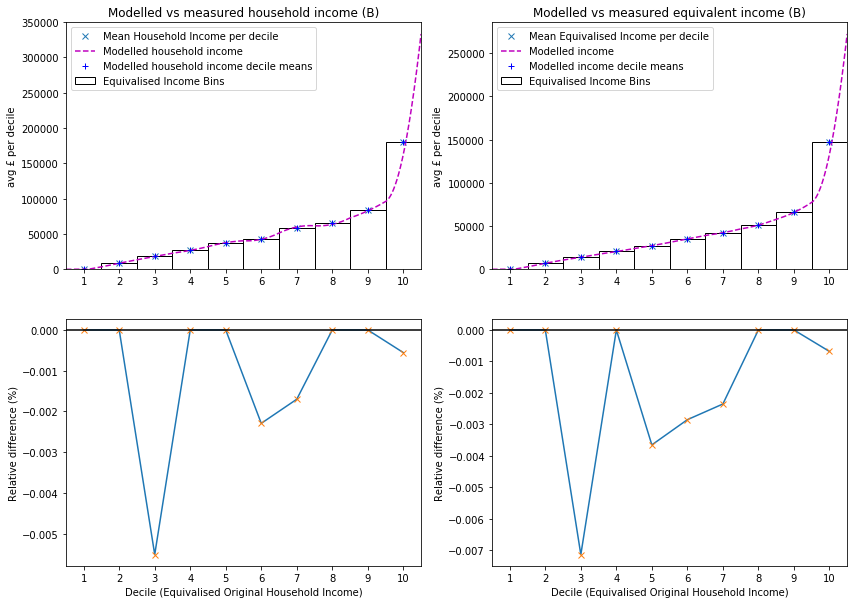

In [27]:
# need a lot of bins so sample it fully
# set up some arrays
relBinB=1e-6 # bin size as fraction of to population
narrB=np.arange(0,1,relBinB) # position of bin in entire population (from 0=lowest income to 1=highest income)
harrB=np.zeros_like(narrB) # will store number of households per group

# generate the modelled income for total household income and equivali
yarrHhB=np.array(modelB(narrB,Eq=False)) # Total Household Income
yarrEqB=np.array(modelB(narrB,Eq=True)) # Equivalised Income

origHhModB=np.zeros_like(origIncome) # array to store model household income
origEqModB=np.zeros_like(origIncome) # array to store model equivalised income

# cycle through deciles
for q in np.arange(1,11):
    # get households in model in that decile
    ind=np.where((narrB<q/10)&(narrB>=(q-1)/10))
    yind=yarrHhB[ind]
    # calculate number of households per bin
    harrB[ind]=nHouseholds[q-1]/len(yind)
    # print(q,yarr[ind])
    
    # calculate mean modelled income for that decile
    origHhModB[q-1]=np.mean(yarrHhB[ind])
    origEqModB[q-1]=np.mean(yarrEqB[ind])

# calculate offsets of model from data
origHhOffsetB=origHhModB-origIncome
origEqOffsetB=origEqModB-origIncomeEq

# sum total incomes
totEqIncomeMeasB=np.sum(origIncomeEq*nHouseholds*nEquiv) # total equivalised income (data)
totEqIncomeModB=np.sum(origEqModB*nHouseholds*nEquiv) # total equivalised income (model B)
totEqIncomeRelErrB=(totEqIncomeModB/totEqIncomeMeasB)-1 # relative offset of model N w.r.t. data for equivalised income
# check by summing the whole model (not summing the deciles)
totEqIncomeModBcheck=np.sum(yarrEqB*harrB) # total equivalised income (model B, check method)
totEqIncomeRelErrBcheck=(totEqIncomeModBcheck/totEqIncomeMeasB)-1 # relative model B (check) offset w.r.t data for equivalised income

totHhIncomeMeasB=np.sum(origIncome*nHouseholds) # total household income (data)
totHhIncomeModB=np.sum(origHhModB*nHouseholds) # total household income (model B)
totHhIncomeRelErrB=(totHhIncomeModB/totHhIncomeMeasB)-1 # relative offset of model N w.r.t. data for household income
# check by summing the whole model
totHhIncomeModBcheck=np.sum(yarrHhB*harrB) # total equivalised income (model B, check method)
totHhIncomeRelErrBcheck=(totHhIncomeModBcheck/totHhIncomeMeasB)-1 # relative model B (check) offset w.r.t data for household income

# plot results
plot.figure(figsize=(14,10))
plot.subplot(2,2,1)
plot.plot(decile-0.5,origIncome,'x',label='Mean Household Income per decile')
plot.bar(decile-0.5,origIncome,width=1,ls='-',fc='m',fill=None,label='Equivalised Income Bins')
plot.plot(narrB*10,yarrHhB,'m--',label='Modelled household income')
plot.plot(decile-0.5,origHhModB,'b+',label='Modelled household income decile means')
plot.xlim(0,10)
plot.xticks(np.arange(0.5,10.5),np.arange(1,11))
# plot.ylim(0,plot.ylim()[1])
# plot.xlabel(decLab)
plot.ylabel('avg £ per decile')
plot.title('Modelled vs measured household income (B)')
plot.legend()

plot.subplot(2,2,2)
plot.plot(decile-0.5,origIncomeEq,'x',label='Mean Equivalised Income per decile')
plot.bar(decile-0.5,origIncomeEq,width=1,ls='-',fc='m',fill=None,label='Equivalised Income Bins')
plot.plot(narrB*10,yarrEqB,'m--',label='Modelled income')
plot.plot(decile-0.5,origEqModB,'b+',label='Modelled income decile means')
plot.xlim(0,10)
plot.xticks(np.arange(0.5,10.5),np.arange(1,11))
# plot.ylim(0,plot.ylim()[1])
# plot.xlabel(decLab)
plot.ylabel('avg £ per decile')
plot.title('Modelled vs measured equivalent income (B)')
plot.legend()

plot.subplot(2,2,3)
plot.plot(decile,100*(origHhModB/origIncome - 1))
plot.plot(decile,100*(origHhModB/origIncome - 1),'x')
plot.xlabel(decLab)
plot.axhline(0,c='k')
plot.xlim(0.5,10.5)
plot.xticks(np.arange(1,11))
plot.ylabel('Relative difference (%)')
# plot.title('Modelled vs measured household income (B)')

plot.subplot(2,2,4)
plot.plot(decile,100*(origEqModB/origIncomeEq - 1))
plot.plot(decile,100*(origEqModB/origIncomeEq - 1),'x')
plot.xlabel(decLab)
plot.axhline(0,c='k')
plot.xlim(0.5,10.5)
plot.xticks(np.arange(1,11))
plot.ylabel('Relative difference (%)')
# plot.title('Modelled vs measured household income (B)')

print('Total equivalised income (measured): £{:.1f}bn'.format(totEqIncomeMeasB/1e9))
print('Total equivalised income (modelled B): £{:.1f}bn'.format(totEqIncomeModB/1e9))
print('Relative Error (B): {:.2f}%'.format(100*totEqIncomeRelErrB))
# print('Total income (modelled B check): £{:.1f}bn'.format(totEqIncomeModBcheck/1e9))
# print('Relative Error (B check): {:.2f}%'.format(100*totIncomeRelErrBcheck))
print('Total household income (measured): £{:.1f}bn'.format(totHhIncomeMeasB/1e9))
print('Total household income (modelled B): £{:.1f}bn'.format(totHhIncomeModB/1e9))
print('Relative Error (B): {:.2f}%'.format(100*totHhIncomeRelErrB))


Much better agreement than model A, by design, with better agreement with individual bins. Maximum income is still much too low, partly due to size of bins

# Model taxable benefits
Taxable benefits are modelled with a 2nd-order polynomial across each band, with the decile boundaries modway between the means. The first decile minimum and last decile maximum are defined such that the gradient is constant.

Total measured taxable benefits: £82.9bn
Total modelled taxable benefits: £82.9bn
Relative error: -0.0%


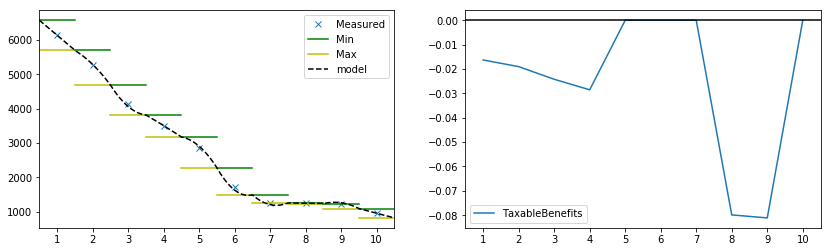

In [12]:
tb0=np.zeros_like(decile) # bottom of decile
tb1=np.zeros_like(decile) # top of decile
for q in range(0,9):
    # boundary of adjacent deciles is average of the two decile means
    tb1[q]=0.5*(taxableBen[q]+taxableBen[q+1])
    tb0[q+1]=tb1[q]

# minimum and maximum taxable benefits defined to continue gradient at top/bottom of deciles
tb0[0]=tb1[0]+np.array(taxableBen[0]-np.array(taxableBen[1]))
tb1[-1]=tb0[-1]+(np.array(taxableBen)[-1]-np.array(taxableBen)[-2])

tbbar=np.array(taxableBen) # data of mean taxable benefits
tb05=0.5*(tb0+tb1) # mean of max/min of decile
dtb=tb1-tb0 # range across decile

model_tb=np.zeros((len(tb0),2)) # array for model parameters
model_tb[:,0]=6*(tbbar - tb05) + dtb
model_tb[:,1]=6*(tb05 - tbbar)

def taxBenModel(n,y0=tb0,model=model_tb,y1=tb1):
    if np.isscalar(n):
        q=np.min([9,int(np.floor(n*10))])
    else:
        q = np.floor(n*10).astype(int)
    tb=np.maximum(0,y0[q] + model[q,0]*(10*n-q) + model[q,1]*(10*n-q)**2)
#     tb=np.maximum(0,y0[q] + (y1[q]-y0[q])*(10*n-q))
    return(tb)

# create detailed model with many bins across population
ntb=np.arange(0,1,1e-6) # bin across population (0=lowest income, 1=highest income)
tbharr=np.zeros_like(ntb) # array for modelled benefits
tbmod=taxBenModel(ntb) # modelled taxable benefits for decile

taxBenMod=np.zeros_like(taxableBen) # array to store modelled mean taxable benefits for deciles
for q in np.arange(1,11):
    # get bins in decile
    ind=np.where((ntb<q/10)&(ntb>=(q-1)/10))
    tbind=tbmod[ind]
    # number of households in bin
    tbharr[ind]=nHouseholds[q-1]/len(tbind)
    taxBenMod[q-1]=np.mean(tbmod[ind]) # mean taxable benefit in decile

# compute totals
totTaxBenMeas=np.sum(taxableBen*nHouseholds) # total taxable benefits (data)
totTaxBenMod=np.sum(taxBenMod*nHouseholds) # total taxable benefits (model)
totTaxBenModDet=np.sum(tbmod*tbharr) # total taxable benefit (detailed model method)
totTaxBenRelErr=totTaxBenMod/totTaxBenMeas - 1 # relative error of model w.r.t. data for taxable benefits
totTaxBenRelErrDet=totTaxBenModDet/totTaxBenMeas - 1 # relative error of model w.r.t. data for taxable benefits (detailed model method)
print('Total measured taxable benefits: £{:.1f}bn'.format(totTaxBenMeas/1e9))
print('Total modelled taxable benefits: £{:.1f}bn'.format(totTaxBenMod/1e9))
print('Relative error: {:.1f}%'.format(100*totTaxBenRelErr))
# print('Total modelled taxable benefits (detailed): £{:.1f}bn'.format(totTaxBenModDet/1e9))
# print('Relative error: {:.1f}%'.format(100*totTaxBenRelErrDet))

# plot taxable benefits
plot.figure(figsize=(14,4))
plot.subplot(1,2,1)
# plot.bar(decile-0.5,taxableBen,width=1,ls='-',fc='m',fill=None,label='Measured bins')
plot.plot(decile-0.5,taxableBen,'x',label='Measured')
plot.plot([decile[0]-1,decile[0]],[tb0[0],tb0[0]],'g',label='Min')
plot.plot([decile[0]-1,decile[0]],[tb1[0],tb1[0]],'y',label='Max')
for q in range(1,10):
    plot.plot([decile[q]-1,decile[q]],[tb0[q],tb0[q]],'g')
    plot.plot([decile[q]-1,decile[q]],[tb1[q],tb1[q]],'y')
# plot.plot(decile,tb0)
# plot.plot(decile-1,tb1)
plot.xlim(0,10)
plot.xticks(np.arange(0.5,10.5),np.arange(1,11))
plot.plot(ntb*10,tbmod,'k--',label='model')
plot.legend()

plot.subplot(1,2,2)
plot.plot(decile,100*(taxBenMod/taxableBen-1))
plot.xlim(0.5,10.5)
plot.xticks(np.arange(1,11))
plot.axhline(0,c='k')
plot.legend()

Good enough! Some wiggles around decile 7, but that's OK.

### Test taxable income
Can we accurately model the taxable income?

The measured "direct tax" is the total of income tax, NI, student loan repayments and council tax (minus rebates).

Assume it is calculated based on original income + direct benefits (pension, DSA, child benefit etc.).

Model it with 2018/19 tax bands.

Caveat: we are working with total household income. Treating this as if it is a single individual's income will inflate the income tax. But we are ignoring NI and council tax. We can calculate the income tax only by assuming the taxable income (original income + taxable benefits) is divided between two people. Because income tax is progressive, this reduces the total tax paid. We can also assume this is split 80:20 between two people, which may be more representative of top earners.

In [13]:
# set tax bands and thresholds
tax20=11850
tax40=34500+tax20
tax45=150000+tax20
taxBandsNow=[[tax20,0.2],[tax40,0.2],[tax45,0.05]]

# calculate tax paid for given income
def dirTaxModFunc(inc,bands=taxBandsNow):
    if np.isscalar(inc):
        tax=0
        for t in range(len(bands)):
            if inc>bands[t][0]:
                tax=tax+(inc-bands[t][0])*bands[t][1]
        return tax
    else:
#         print(len(inc))
        inc=np.array(inc)
        tax=np.zeros_like(inc)
        for t in range(len(bands)):
#             print(t,bands[t])
            ind=np.where(inc > bands[t][0])
            if len(ind[0])>0:
#                 print(len(ind[0]),len(tax[ind[0]]),len((inc[ind[0]]-bands[t][0])*bands[t][1]))
                tax[ind[0]]=tax[ind[0]]+(inc[ind[0]]-bands[t][0])*bands[t][1]
        return tax


otherTax=dirTax-incomeTax # tax that isn't income tax (i.e. not income-dependent)
dirIncomeTaxMod=dirTaxModFunc(origIncome+taxableBen) # modelled income tax paid on income + taxable benefits
fracIncomeTaxMod=dirIncomeTaxMod/(dirIncomeTaxMod+otherTax) # fraction of tax that is income tax

# alternative method - assume we tax all income
dirTotTaxMod=dirTaxModFunc(origIncome+dirBen) #total tax modeled as income tax on total income (inc all benefits)

Find the income split that best matches the income tax paid

Text(0,0.5,'income fraction of dominant earner')

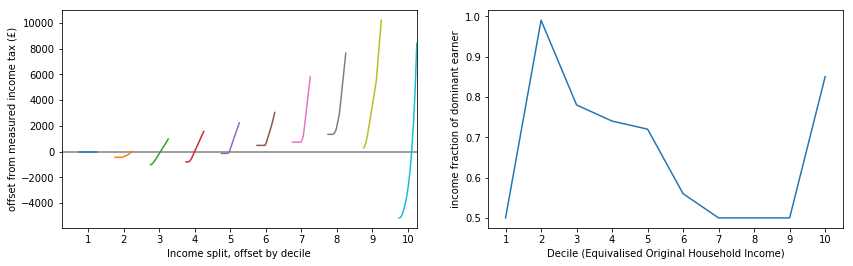

In [14]:
# model based on bins
narrT=np.arange(0,1,relBinB) # bin location in population (0=lowest income, 1=highest income)
tInc=np.array(modelB(narrT,Eq=False)) # model household income (model B)
taxBen=np.array(taxBenModel(narrT)) # model taxable benefits
tIncomePaid=np.zeros_like(narrT) # array to store income tax paid baed on best split

# use range of splits of income from 0.5 to 1
splits=np.arange(0.5,1.01,0.01)
bestSplit=np.zeros(10) # best split for a given decile
splitTax=np.zeros((10,len(splits))) # tax paid for a given decile at range of splits

# set up plot
plot.figure(figsize=(14,4))
plot.subplot(1,2,1)
plot.axhline(0,c='gray')
# loop over decile
for q in range(0,10):
    # get bins in decile
    ind=np.where((narrT<(q+1)/10)&(narrT>=(q)/10))
    # loop over splits
    for s in range(len(splits)):
        sp=splits[s]
        # calculate tax paid for a given split
        splitTax[q,s]=np.mean(dirTaxModFunc(sp*(tInc[ind]+taxBen[ind]))+dirTaxModFunc((1-sp)*(tInc[ind]+taxBen[ind])))
    # calculate split that gives the closest modelled income tax to data
    bestSplit[q]=splits[np.argmin((splitTax[q,:]-incomeTax[q])**2)]
    # calculate income paid based on best split
    tIncomePaid[ind]=dirTaxModFunc(bestSplit[q]*(tInc[ind]+taxBen[ind])) + dirTaxModFunc((1-bestSplit[q])*(tInc[ind]+taxBen[ind]))
    # plot offset in modelled vs measured income tax for range of splits
    plot.plot(splits+q,splitTax[q,:]-incomeTax[q])    
plot.xlim(0,10)
plot.xticks(np.arange(0.75,10.75),np.arange(1,11))
plot.xlabel('Decile (income tax split within decile from 0.5-1)')
plot.ylabel('offset from measured income tax (£)')

plot.subplot(1,2,2)
plot.plot(decile,bestSplit)
plot.xlabel(decLab)
plot.xlim(0.5,10.5)
plot.xticks(np.arange(1,11))
plot.ylabel('income fraction of dominant earner')
# plot.axhline(0)
# plot.xlim(0,10)

For some deciles, there's no best-fit, implying that the 2-person model doesn't work - they possibly have a higher tax-free allowance. So either the income is from more than 2 people (seems possible) or they pay less tax (e.g. by transferring tax-free allowance).

Text(0,0.5,'Income (£)')

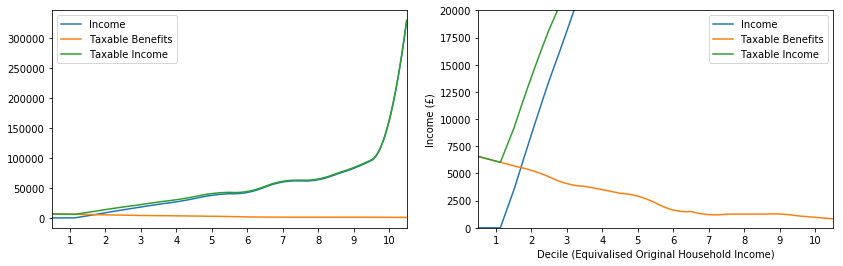

In [28]:
# model the tax paid in more detail, using the income model above
dirTotTaxModDet=np.zeros(10) # total tax paid (detailed model, 1 person)
dirIncomeTaxModDet=np.zeros(10) #income tax paid (detailed model, 1 person)
fracIncomeTaxModDet=np.zeros(10) # fraction of tax that is income tax (detailed model, 1 person)
dirIncomeTaxModDet2p=np.zeros(10) # income tax paid (detailed model, 2 people)
dirTotTaxModDet2p=np.zeros(10) # total tax paid (detailed mode, 2 people)
fracIncomeTaxModDet2p=np.zeros(10) # fraction of tax that is income tax (detailed model, 1 person)

# set bin size
relBinT=1e-3 # bin size as fraction of total population
narrT=np.arange(0,1,relBinT) # bin position in population (0=lowest paid, 1=highest paid)
harrT=np.zeros_like(narrT) # households in bin

# model income and taxable benefits
tInc=np.array(modelB(narrT,Eq=False)) # modelled income
taxBen=np.array(taxBenModel(narrT)) # modelled taxable income
tTotPaid=np.zeros_like(narrT) # modelled total tax paid (lazy model)
tIncomePaid=np.zeros_like(narrT) # modelled income tax (1 person)
tIncomePaid2p=np.zeros_like(narrT) # modelled income tax (2 people)
# tIncomePaid2ptop=np.zeros_like(narrT)
# tTotPaid=dirTaxModFunc(tInc)
# tTotPaid=dirTaxModFunc(tInc)

# loop over deciles
for q in np.arange(1,11):
    # get bins in deciles
    ind=np.where((narrT<q/10)&(narrT>=(q-1)/10))
    harrT[ind]=nHouseholds[q-1]/len(ind) # householes in bin
    # income tax (1 person)
    tIncomePaid[ind]=dirTaxModFunc(tInc[ind]+taxBen[ind])
    # income tax paid (2 people, based on best split for that decile)
    tIncomePaid2p[ind]=dirTaxModFunc(bestSplit[q-1]*(tInc[ind]+taxBen[ind])) + dirTaxModFunc((1-bestSplit[q-1])*(tInc[ind]+taxBen[ind])) #income tax paid (2 peopl)
    # total tax paid assuming all tax is income tax
    tTotPaid[ind]=dirTaxModFunc(tInc[ind]+taxBen[ind])

    # calculate averages in decile
    dirIncomeTaxModDet[q-1]=np.mean(tIncomePaid[ind]) # mean income tax in decile (1 person)
    dirIncomeTaxModDet2p[q-1]=np.mean(tIncomePaid2p[ind]) # mean income tax in decile (2 people)
    dirTotTaxModDet[q-1]=dirIncomeTaxModDet[q-1]+otherTax[q-1] # total tax in decile (1 person)
    fracIncomeTaxModDet[q-1]=dirIncomeTaxModDet[q-1]/(dirIncomeTaxModDet[q-1]+otherTax[q-1]) # fraction of income 
    fracIncomeTaxModDet2p[q-1]=dirIncomeTaxModDet2p[q-1]/(dirIncomeTaxModDet2p[q-1]+otherTax[q-1])
    dirTotTaxModDet2p[q-1]=dirIncomeTaxModDet2p[q-1]+otherTax[q-1] # total tax in decile (2 people)

plot.figure(figsize=(14,4))
plot.subplot(1,2,1)
plot.plot(narrT*10,tInc,label='Income')
plot.plot(narrT*10,taxBen,label='Taxable Benefits')
plot.plot(narrT*10,tInc+taxBen,label='Taxable Income')
plot.xlim(0,10)
plot.xticks(np.arange(0.5,10.5),np.arange(1,11))
plot.legend()

plot.subplot(1,2,2)
plot.plot(narrT*10,tInc,label='Income')
plot.plot(narrT*10,taxBen,label='Taxable Benefits')
plot.plot(narrT*10,tInc+taxBen,label='Taxable Income')
plot.ylim(0,20000)
plot.xlim(0,10)
plot.xticks(np.arange(0.5,10.5),np.arange(1,11))
plot.legend()
plot.xlabel(decLab)
plot.ylabel('Income (£)')


Measured tax paid: £356.4bn
Measured income tax paid: £238.6bn
Detailed Modelled income tax paid (1 person): £340.6bn
Detailed Relative error: 42.7%
Detailed Modelled income tax paid (2 people): £243.6bn
Detailed Relative error: (2 people) 2.1%
Detailed Modelled total tax paid (2 people + other): £361.4bn
Detailed Relative error: (2 people + other) 1.4%


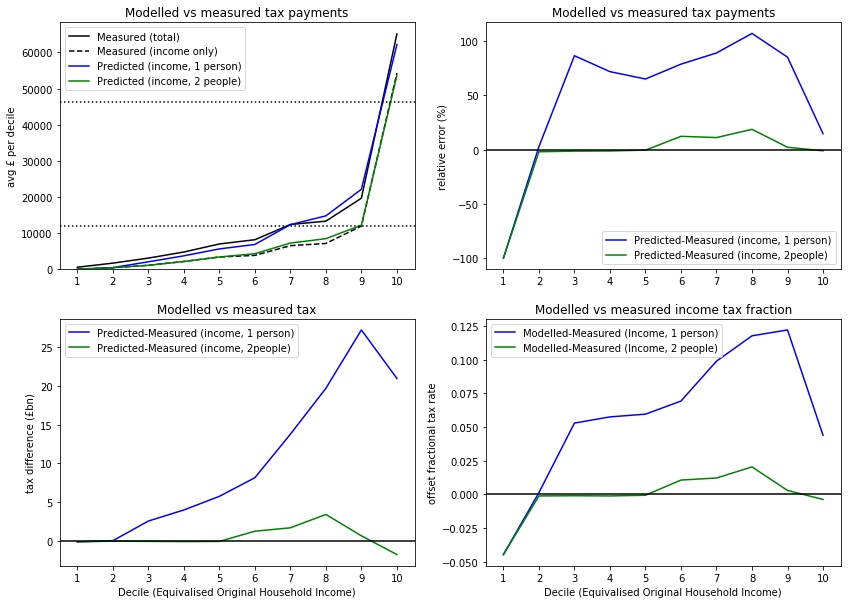

In [34]:
# plot the model vs the measured tax payments
plot.figure(figsize=(14,10))
plot.subplot(2,2,1)
plot.plot(decile,dirTax,'k-',label='Measured (total)')
plot.plot(decile,incomeTax,'k--',label='Measured (income only)')
plot.plot(decile,dirIncomeTaxModDet,'b-',label='Predicted (income, 1 person)')
plot.plot(decile,dirIncomeTaxModDet2p,'g-',label='Predicted (income, 2 people)')
plot.xlim(0.5,10.5)
plot.xticks(np.arange(1,11))
plot.ylim(0,plot.ylim()[1])
# plot.xlabel(decLab)
plot.ylabel('avg £ per decile')
plot.axhline(tax20,c='k',ls=':')
plot.axhline(tax40,c='k',ls=':')
plot.axhline(tax45,c='k',ls=':')
plot.legend()
plot.title('Modelled vs measured tax payments')

# plot relative error of model to data for income tax (1 vs 2 people)
plot.subplot(2,2,2)
plot.plot(decile,100*(dirIncomeTaxModDet/incomeTax-1),'b-',label='Predicted-Measured (income, 1 person)')
# plot.plot(decile,100*(dirIncomeTaxModDet/incomeTax-1),'r:',label='Predicted-Measured (income, detailed)')
plot.plot(decile,100*(dirIncomeTaxModDet2p/incomeTax-1),'g-',label='Predicted-Measured (income, 2people)')
plot.xlim(0.5,10.5)
plot.xticks(np.arange(1,11))
# plot.xlim(0,plot.xlim()[1])
# plot.ylim(0,plot.ylim()[1])
# plot.xlabel(decLab)
plot.ylabel('relative error (%)')
plot.axhline(0,c='k')
plot.legend()
plot.title('Modelled vs measured tax payments')

# calculate effective tax rates
effTaxTotMeas=dirTax/(origIncome+dirBen) # measured total tax as fraction of income + benefits
effTaxIncomeMeas=incomeTax/origIncome # measured income tax as fraction of original income
effTaxIncomeModDet=dirIncomeTaxModDet/origIncome # modelled income tax as fracion of original income (1 person)
effTaxIncomeModDet2p=dirIncomeTaxModDet2p/origIncome # modelled income tax as fracion of original income (2 people)

# plot relative offset of model vs data
plot.subplot(2,2,3)
plot.plot(decile,(dirIncomeTaxModDet-incomeTax)*nHouseholds/1e9,'b-',label='Predicted-Measured (income, 1 person)')
plot.plot(decile,(dirIncomeTaxModDet2p-incomeTax)*nHouseholds/1e9,'g-',label='Predicted-Measured (income, 2people)')
plot.xlim(0.5,10.5)
plot.xticks(np.arange(1,11))
# plot.ylim(0,plot.ylim()[1])
plot.xlabel(decLab)
plot.ylabel('tax difference (£bn)')
plot.axhline(0,c='k')
# plot.axhline(tax40,c='k',ls=':')
# plot.axhline(tax45,c='k',ls=':')
plot.legend()
plot.title('Modelled vs measured tax')

# plot effective tax rate
plot.subplot(2,2,4)
# plot.plot(decile,effTaxTotMod-effTaxTotMeas,'k-',label='Modelled-Measured (Total)')
plot.plot(decile,effTaxIncomeModDet-effTaxIncomeMeas,'b-',label='Modelled-Measured (Income, 1 person)')
plot.plot(decile,effTaxIncomeModDet2p-effTaxIncomeMeas,'g-',label='Modelled-Measured (Income, 2 people)')
plot.xlim(0.5,10.5)
plot.xticks(np.arange(1,11))
# plot.ylim(0,plot.ylim()[1])
plot.xlabel(decLab)
plot.ylabel('offset fractional tax rate')
plot.axhline(0,c='k')
# plot.axhline(tax40,c='k',ls=':')
# plot.axhline(tax45,c='k',ls=':')
plot.legend()
plot.title('Modelled vs measured income tax fraction')

# calculate totals for whole UK
totTaxMeas=np.sum(dirTax*nHouseholds) # measured total tax
totIncomeTaxMeas=np.sum(incomeTax*nHouseholds) # measured income tax
totIncomeTaxModDet=np.sum(dirIncomeTaxModDet*nHouseholds) # modelled income tax (1 person)
totIncomeTaxModDet2p=np.sum(dirIncomeTaxModDet2p*nHouseholds) # modelled income tax (2 people)
totIncomeTaxDetRelErr=totIncomeTaxModDet/totIncomeTaxMeas - 1 # relative offset of model w.r.t. data for income tax (1 person)
totIncomeTaxDetRelErr2p=totIncomeTaxModDet2p/totIncomeTaxMeas - 1 # relative offset of model w.r.t. data for income tax (2 people)

totTaxModDet=np.sum(dirTotTaxModDet*nHouseholds) # modelled total tax (1 person) 
totTaxDetRelErr=totTaxModDet/totTaxMeas - 1 # relative offset of model w.r.t. data for total tax (1 person)
totTaxModDet2p=np.sum((dirTotTaxModDet2p)*nHouseholds) # modelled total tax (2 people) 
totTaxDetRelErr2p=totTaxModDet2p/totTaxMeas - 1 # relative offset of model w.r.t. data for total tax (2 people )

print('Measured tax paid: £{:.1f}bn'.format(totTaxMeas/1e9))
print('Measured income tax paid: £{:.1f}bn'.format(totIncomeTaxMeas/1e9))

print('Detailed Modelled income tax paid (1 person): £{:.1f}bn'.format(totIncomeTaxModDet/1e9))
print('Detailed Relative error: {:.1f}%'.format(totIncomeTaxDetRelErr*100))
print('Detailed Modelled income tax paid (2 people): £{:.1f}bn'.format(totIncomeTaxModDet2p/1e9))
print('Detailed Relative error: (2 people) {:.1f}%'.format(totIncomeTaxDetRelErr2p*100))
print('Detailed Modelled total tax paid (2 people + other): £{:.1f}bn'.format(totTaxModDet2p/1e9))
print('Detailed Relative error: (2 people + other) {:.1f}%'.format(totTaxDetRelErr2p*100))


# print(np.sum(data['DirectTax']*nHouseholds))

totalBenefits=np.sum(dirBen*nHouseholds)
totalDirectTax=np.sum(dirTax*nHouseholds)
totalNetIncome=totalDirectTax-totalBenefits




If we only consider total tax then this understimates total tax paid in some bands, and overerestimates in others. How inaccurate is it, and how does the total compare?

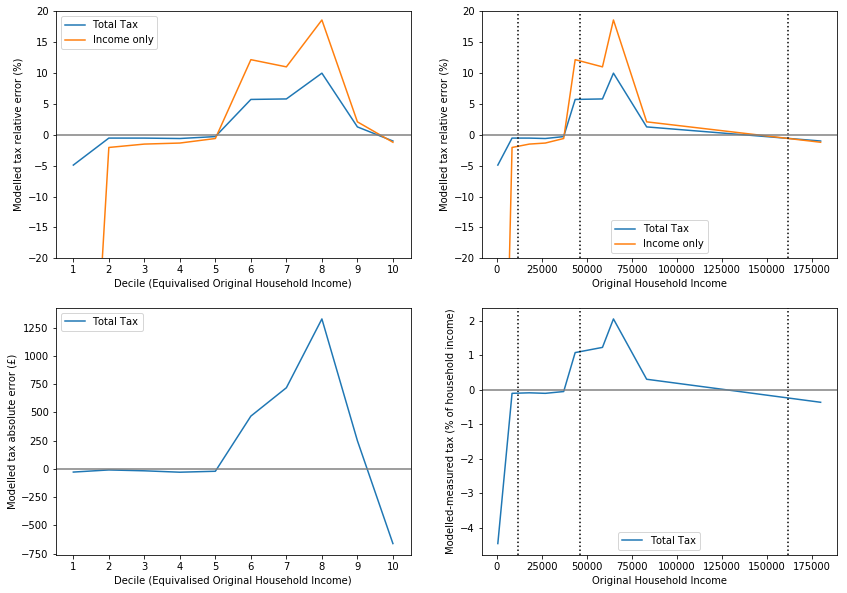

In [36]:
# relative offset of total and income tax model vs data, plotted against decile
plot.figure(figsize=(14,10))
plot.subplot(2,2,1)
plot.plot(decile,100*(dirTotTaxModDet2p/dirTax-1),label='Total Tax')
plot.plot(decile,100*(dirIncomeTaxModDet2p/incomeTax-1),label='Income only')
plot.xlabel(decLab)
plot.ylabel('Modelled tax relative error (%)')
plot.ylim(-20,20)
plot.xlim(0.5,10.5)
plot.xticks(np.arange(1,11))
plot.axhline(0,c='gray')
plot.legend()

# relative offset of total and income tax model vs data, plotted against originalincome
plot.subplot(2,2,2)
plot.plot(origIncome,100*(dirTotTaxModDet2p/dirTax-1),label='Total Tax')
plot.plot(origIncome,100*(dirIncomeTaxModDet2p/incomeTax-1),label='Income only')
plot.xlabel('Original Household Income')
plot.ylabel('Modelled tax relative error (%)')
plot.ylim(-20,20)
# plot.xlim(1,10)
plot.axvline(tax20,c='k',ls=':')
plot.axvline(tax40,c='k',ls=':')
plot.axvline(tax45,c='k',ls=':')
plot.axhline(0,c='gray')
plot.legend()

# absolute offset of total and income tax model vs data, plotted against decile
plot.subplot(2,2,3)
plot.plot(decile,dirTotTaxModDet2p-dirTax,label='Total Tax')
# plot.plot(decile,dirIncomeTaxModDet2p-incomeTax,label='Income only')
plot.xlabel(decLab)
plot.ylabel('Modelled tax absolute error (£)')
# plot.ylim(-20,20)
plot.xlim(0.5,10.5)
plot.xticks(np.arange(1,11))
plot.axhline(0,c='gray')
plot.legend()

# offset of total and income tax model vs data relative to household income, plotted against original income
plot.subplot(2,2,4)
plot.plot(origIncome,100*(dirTotTaxModDet2p-dirTax)/origIncome,label='Total Tax')
# plot.plot(origIncome,dirIncomeTaxModDet2p-incomeTax,label='Income only')
plot.xlabel('Original Household Income')
plot.ylabel('Modelled-measured tax (% of household income)')
# plot.ylim(-20,20)
# plot.xlim(1,10)
plot.axvline(tax20,c='k',ls=':')
plot.axvline(tax40,c='k',ls=':')
plot.axvline(tax45,c='k',ls=':')
plot.axhline(0,c='gray')
plot.legend()


The errors are low  in lower deciles, but with 5-10% over-prediction for total tax in higher deciles. Note that the income tax for the lowest decile is very poorly predicted, but is a small contributor to the total. The effect is a few percent of household income.


# The national picture
How does the nation do interms of tax and benefits. In what follows we do not use the detailed income model, which is known to be inaccurate, reliying instead on the averages within deciles.

In [37]:
# calculate total benfits and tax and net national income
totalBenefits=np.sum(dirBen*nHouseholds)/1e9 # total benefits received
totalDirectTax=np.sum(dirTax*nHouseholds)/1e9 # total tax paid
totalNetIncome=totalDirectTax-totalBenefits #total net income
print('Total direct benefits: £{}bn'.format(int(totalBenefits)))
print('Total direct tax: £{}bn'.format(int(totalDirectTax)))
print('Net National Income: £{}bn'.format(int(totalNetIncome)))

Total direct benefits: £185bn
Total direct tax: £356bn
Net National Income: £170bn


### Plot incomes across deciles

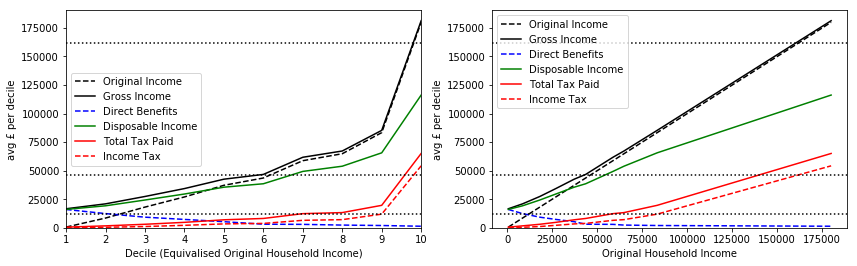

In [41]:
plot.figure(figsize=(14,4))
plot.subplot(1,2,1)
plot.plot(decile,origIncome,'k--',label='Original Income')
plot.plot(decile,grossIncome,'k-',label='Gross Income')
plot.plot(decile,dirBen,'b--',label='Direct Benefits')
plot.plot(decile,dispIncome,'g-',label='Disposable Income')
plot.plot(decile,dirTax,'r-',label='Total Tax Paid')
plot.plot(decile,incomeTax,'r--',label='Income Tax')
plot.legend()
plot.xlim(1,10)
plot.ylim(0,plot.ylim()[1])
plot.xlabel(decLab)
plot.ylabel('avg £ per decile')
plot.axhline(tax20,c='k',ls=':')
plot.axhline(tax40,c='k',ls=':')
plot.axhline(tax45,c='k',ls=':')

plot.subplot(1,2,2)
plot.plot(origIncome,origIncome,'k--',label='Original Income')
plot.plot(origIncome,grossIncome,'k-',label='Gross Income')
plot.plot(origIncome,dirBen,'b--',label='Direct Benefits')
plot.plot(origIncome,dispIncome,'g-',label='Disposable Income')
plot.plot(origIncome,dirTax,'r-',label='Total Tax Paid')
plot.plot(origIncome,incomeTax,'r--',label='Income Tax')
plot.legend()
plot.ylim(0,plot.ylim()[1])
plot.xlabel('Original Household Income')
plot.ylabel('avg £ per decile')
plot.axhline(tax20,c='k',ls=':')
plot.axhline(tax40,c='k',ls=':')
plot.axhline(tax45,c='k',ls=':')

## New model (household universal benefits)
Construct a new model, with uniform benefits, and different tax bands

Benefits are now comprised of "universal benefits", which are the same for every household, and the subset of benefits which only apply to some people (and so change between deciles). These include diability benefit, child benefit etc.

An alternative model assumes that universal benefits are paid to individuals, so the house

In [72]:
def dirTaxModFuncNew(inc,bands=[[0,0.425],[50000,0.425],[100000,0.425]]):
    if np.isscalar(inc):
        tax=0
        for t in range(len(bands)):
            if inc >= bands[t][0]:
                # income is in band
                if t<len(bands)-1:
                    # max of band is next band minimum
                    maxb=bands[t+1][0]
                else:
                    # no max
                    maxb=np.Infinity
                # add tax from band
                tax = tax + (np.min([inc,maxb])-bands[t][0])*bands[t][1]
        return tax
    else:
        # print(inc)
        inc=np.array(inc)
        tax=np.zeros_like(inc)
        for t in range(len(bands)):
            # print(t,bands[t])
            for i in range(len(inc)):
                if inc[i] >= bands[t][0]:
                    # income is in band
                    if t<len(bands)-1:
                        # max of band is next band minimum
                        maxb=bands[t+1][0]
                    else:
                        # no max
                        maxb=np.Infinity
                    # add tax from band
                    tax[i] = tax[i] + (np.min([inc[i],maxb])-bands[t][0])*bands[t][1]
            # for i in range(len(inc)):
                # print(inc[i],tax[i])
        return tax


In [189]:
# set out the benfits and tax thresholds
ubiModels={'model1':{'uniBen':17000,'taxBands':[[0,0.41],[50000,0.41],[100000,0.41]],'desc':'17k UBI, 41% tax','color':'b'},
           'model2':{'uniBen':14000,'taxBands':[[0,0.35],[50000,0.35],[100000,0.35]],'desc':'14k UBI, 35% tax','color':'g'},
           'model3':{'uniBen':17000,'taxBands':[[0,0.3],[20000,0.42],[50000,0.5]],'desc':'17k UBI, tax 30%/42%/50% @ 0/£20k/£50k','color':'r'},
           'model4':{'uniBen':14000,'taxBands':[[0,0],[8000,0.28],[30000,0.45],[100000,0.55]],'desc':'14k UBI, tax 28%/45%/55% @ £8/£30k/£100k','color':'m'}
          }
# uniBen=17000 # universal income
# uniBen=12000
# # set tax bands and thresholds
# taxBands=[[0,0.41],[50000,0.41],[100000,0.41]]
# taxBands=[[0,0.3],[50000,0.3],[100000,0.3]]

for model in ubiModels:
    m=ubiModels[model]
    print('*** {} ***'.format(m['desc']))
    m['origNew']=origIncome # original income (unchanged)

    # new direct benefits are universal benefits and kept benefits
    m['dirBenNew']=[m['uniBen']]*len(dirBen)
    m['dirBenNew'] = m['dirBenNew'] + keptBen
    m['grossNew']=m['origNew']+m['dirBenNew'] # income and benefits

    m['incomeTaxPaidNew']=np.zeros(10)
    for q in range(10):
        narr=np.arange(q*0.1,(q+1)*0.1,1e-4)
        # calculate taxable income in each tax band
        tInc=modelB(narr,Eq=False)
        tPaidNew=dirTaxModFuncNew(tInc,bands=m['taxBands'])
        m['incomeTaxPaidNew'][q]=np.mean(tPaidNew)

    m['taxPaidNew']=m['incomeTaxPaidNew'] + otherTax
    # calculate disposable income
    m['dispNew']=m['grossNew']-m['taxPaidNew']
    # calculate total benefits and taxes, and compare with old model
    m['totalBenefitsNew']=np.sum(m['dirBenNew']*nHouseholds)/1e9
    m['totalDirectTaxNew']=np.sum(m['taxPaidNew']*nHouseholds)/1e9
    m['totalNetIncomeNew']=m['totalDirectTaxNew']-m['totalBenefitsNew']

    print('Total direct benefits ({}): £{}bn [change £{}bn]'.format(model,int(m['totalBenefitsNew']),int(m['totalBenefitsNew']-totalBenefits)))
    print('Total direct tax ({}): £{}bn [change £{}bn]'.format(model,int(m['totalDirectTaxNew']),int(m['totalDirectTaxNew']-totalDirectTax)))
    print('Net National Income ({}): £{}bn [change £{}bn]'.format(model,int(m['totalNetIncomeNew']),int(m['totalNetIncomeNew']-totalNetIncome)))

    # print(incomeTaxPaidNew)

*** 17k UBI, 41% tax ***
Total direct benefits (model1): £505bn [change £320bn]
Total direct tax (model1): £677bn [change £320bn]
Net National Income (model1): £171bn [change £0bn]
*** 14k UBI, 35% tax ***
Total direct benefits (model2): £423bn [change £237bn]
Total direct tax (model2): £595bn [change £238bn]
Net National Income (model2): £171bn [change £1bn]
*** 17k UBI, tax 30%/42%/50% @ 0/£20k/£50k ***
Total direct benefits (model3): £505bn [change £320bn]
Total direct tax (model3): £677bn [change £321bn]
Net National Income (model3): £171bn [change £1bn]
*** 14k UBI, tax 28%/45%/55% @ £8/£30k/£100k ***
Total direct benefits (model4): £423bn [change £237bn]
Total direct tax (model4): £595bn [change £239bn]
Net National Income (model4): £172bn [change £2bn]


Text(0.5,1,'New model (by income)')

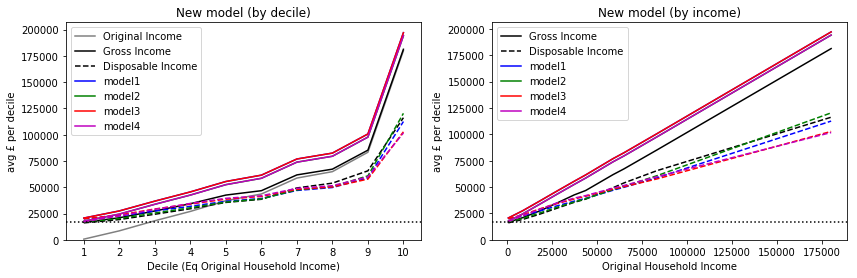

In [190]:
plot.figure(figsize=(14,4))
plot.subplot(1,2,1)
plot.plot(decile,origIncome,ls='-',c='gray',label='Original Income')
plot.plot(decile,grossIncome,'k-',label='Gross Income')
plot.plot(decile,dispIncome,'k--',label='Disposable Income')
for mod in ubiModels:
    m=ubiModels[mod]
    plot.plot(decile,m['grossNew'],ls='-',color=m['color'],label=mod)
    plot.plot(decile,m['dispNew'],ls='--',color=m['color'])
plot.legend()
plot.xlim(0.5,10.5)
plot.xticks(np.arange(1,11))
plot.xlabel('Decile (Eq Original Household Income)')
plot.ylabel('avg £ per decile')
plot.ylim(0,plot.ylim()[1])
plot.axhline(uniBen,c='k',ls=':')
plot.title('New model (by decile)')

plot.subplot(1,2,2)
plot.plot(origIncome,grossIncome,'k-',label='Gross Income')
plot.plot(origIncome,dispIncome,'k--',label='Disposable Income')
for mod in ubiModels:
    m=ubiModels[mod]
    plot.plot(origIncome,m['grossNew'],ls='-',color=m['color'],label=mod)
    plot.plot(origIncome,m['dispNew'],ls='--',color=m['color'])
plot.legend()
plot.xlabel('Original Household Income')
plot.ylabel('avg £ per decile')
plot.ylim(0,plot.ylim()[1])
plot.axhline(uniBen,c='k',ls=':')
plot.title('New model (by income)')


### Compare the models
Compare benefits and taxes

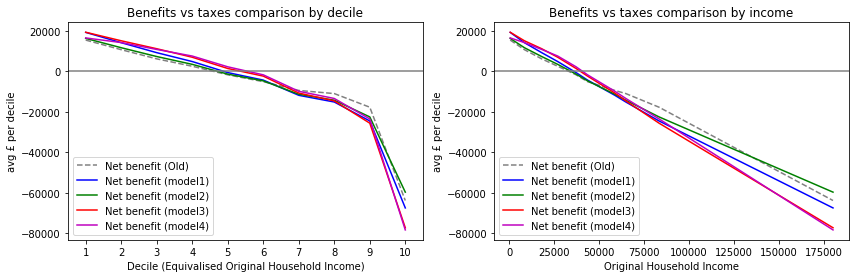

In [191]:
plot.figure(figsize=(14,4))
plot.subplot(1,2,1)
plot.title('Benefits vs taxes comparison by decile')
plot.plot(decile,dirBen-dirTax,ls='--',c='gray',label='Net benefit (Old)')
for mod in ubiModels:
    m=ubiModels[mod]
    plot.plot(decile,m['dirBenNew']-m['taxPaidNew'],c=m['color'],label='Net benefit ({})'.format(mod))
plot.xlim(0.5,10.5)
plot.xticks(np.arange(1,11))
plot.xlabel(decLab)
plot.ylabel('avg £ per decile')
plot.axhline(0,c='gray')
plot.legend()

plot.subplot(1,2,2)
plot.title('Benefits vs taxes comparison by income')
plot.plot(origIncome,dirBen-dirTax,ls='--',c='gray',label='Net benefit (Old)')
for mod in ubiModels:
    m=ubiModels[mod]
    plot.plot(origIncome,m['dirBenNew']-m['taxPaidNew'],c=m['color'],label='Net benefit ({})'.format(mod))
plot.xlabel('Original Household Income')
plot.ylabel('avg £ per decile')
plot.axhline(0,c='gray')
plot.legend()

Those in deciles 0-5 are net beneficiaries, 6-10 are net contributors, and similar to current system

### Plot change across deciles
How does the change affect each decile

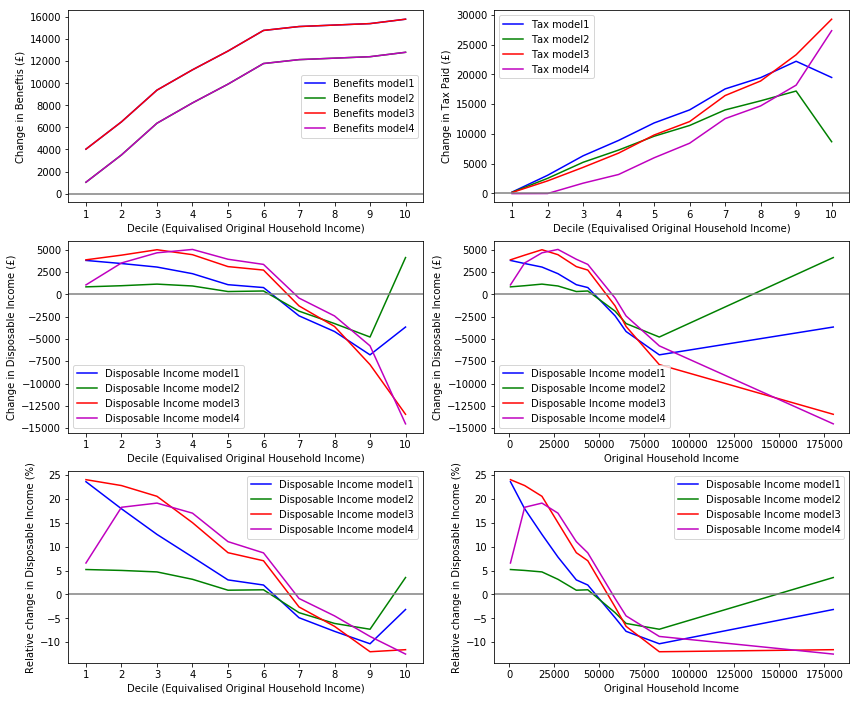

In [194]:
plot.figure(figsize=(14,12))

plot.subplot(3,2,1)
for mod in ubiModels:
    m=ubiModels[mod]
    plot.plot(decile,m['dirBenNew']-dirBen,ls='-',color=m['color'],label='Benefits {}'.format(mod))
plot.legend()
plot.xlim(0.5,10.5)
plot.xticks(np.arange(1,11))
plot.xlabel(decLab)
plot.ylabel('Change in Beneftis (£)')
plot.axhline(0,c='gray')

plot.subplot(3,2,2)
for mod in ubiModels:
    m=ubiModels[mod]
    plot.plot(decile,m['taxPaidNew']-dirTax,ls='-',color=m['color'],label='Tax {}'.format(mod))
plot.legend()
plot.xlim(0.5,10.5)
plot.xticks(np.arange(1,11))
plot.xlabel(decLab)
plot.ylabel('Change in Tax Paid (£)')
plot.axhline(0,c='gray')

plot.subplot(3,2,3)
for mod in ubiModels:
    m=ubiModels[mod]
    plot.plot(decile,m['dispNew']-dispIncome,ls='-',color=m['color'],label='Disposable Income {}'.format(mod))
plot.legend()
plot.xlim(0.5,10.5)
plot.xticks(np.arange(1,11))
plot.xlabel(decLab)
plot.ylabel('Change in Disposable Income (£)')
plot.axhline(0,c='gray')

plot.subplot(3,2,4)
for mod in ubiModels:
    m=ubiModels[mod]
    plot.plot(origIncome,m['dispNew']-dispIncome,ls='-',color=m['color'],label='Disposable Income {}'.format(mod))
plot.legend()
# plot.xlim(0.5,10.5)
# plot.xticks(np.arange(1,11))
plot.xlabel('Original Household Income')
plot.ylabel('Change in Disposable Income (£)')
plot.axhline(0,c='gray')

plot.subplot(3,2,5)
for mod in ubiModels:
    m=ubiModels[mod]
    plot.plot(decile,100*(m['dispNew']/dispIncome-1),ls='-',color=m['color'],label='Disposable Income {}'.format(mod))
plot.legend()
plot.xlim(0.5,10.5)
plot.xticks(np.arange(1,11))
plot.xlabel(decLab)
plot.ylabel('Relative change in Disposable Income (%)')
plot.axhline(0,c='gray')

plot.subplot(3,2,6)
for mod in ubiModels:
    m=ubiModels[mod]
    plot.plot(origIncome,100*(m['dispNew']/dispIncome-1),ls='-',color=m['color'],label='Disposable Income {}'.format(mod))
plot.legend()
# plot.xlim(0.5,10.5)
# plot.xticks(np.arange(1,11))
plot.xlabel('Original Household Income')
plot.ylabel('Relative change in Disposable Income (%)')
plot.axhline(0,c='gray')


Those in deciles 1-6 benefit at a few £100-1000/year, depending on the benefits model. Those in higher deciles suffer more, depending on the tax model

In [200]:
for mod in ubiModels:
    m=ubiModels[mod]
    print('Model: {} ({})'.format(mod,m['desc']))
    print('  UBI: £{}'.format(m['uniBen']))
    print('  Tax bands:')
    for t in range(len(m['taxBands'])):
        print('     £{}: {:.0f}%'.format(m['taxBands'][t][0],100*m['taxBands'][t][1]))

Model: model1 (17k UBI, 41% tax)
  UBI: £17000
  Tax bands:
     £0: 41%
     £50000: 41%
     £100000: 41%
Model: model2 (14k UBI, 35% tax)
  UBI: £14000
  Tax bands:
     £0: 35%
     £50000: 35%
     £100000: 35%
Model: model3 (17k UBI, tax 30%/42%/50% @ 0/£20k/£50k)
  UBI: £17000
  Tax bands:
     £0: 30%
     £20000: 42%
     £50000: 50%
Model: model4 (14k UBI, tax 28%/45%/55% @ £8/£30k/£100k)
  UBI: £14000
  Tax bands:
     £0: 0%
     £8000: 28%
     £30000: 45%
     £100000: 55%
